In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D,Flatten, GlobalMaxPooling1D, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [2]:
dropout = 0.4

visible_1 = Input(shape=(978, 2))
conv1D_1 = Conv1D(64, 2, activation='relu')(visible_1)
maxpooling_1 = GlobalMaxPooling1D()(conv1D_1)
dense_1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(maxpooling_1)
drop_1 = Dropout(dropout)(dense_1)
dense_2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_1)
drop_2 = Dropout(dropout)(dense_2)
dense_3 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_2)
drop_3 = Dropout(dropout)(dense_3)
dense_4 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(drop_3)
drop_4 = Dropout(dropout)(dense_4)
output = Dense(1, activation='linear')(drop_4)
model = Model(inputs=visible_1, outputs=output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 978, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 977, 64)           320       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

In [4]:
# Compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error as metrics for regression

In [5]:
import h5py

h5f = h5py.File('../../data/gene_exp_data_train.h5', 'r')
data_train = h5f['data'][:]
h5f2 = h5py.File('../../data/y_train.h5', 'r')
y_train = h5f2['data'][:]
h5f3 = h5py.File('../../data/gene_exp_data_test.h5', 'r')
data_test = h5f3['data'][:]
h5f4 = h5py.File('../../data/y_test.h5', 'r')
y_test = h5f4['data'][:]

print(data_train.shape)
print(y_train.shape)
print(data_test.shape)
print(y_test.shape)

(350, 978, 2)
(350,)
(75, 978, 2)
(75,)


In [6]:
# Set up ModelCheckpoint to save weights for the epoch with the best validation loss
checkpoint_filepath = "../../data/best_weights_conv1d.h5"
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [7]:
# Train the model and obtain the training history
history = model.fit(data_train, y_train, 
                         validation_data=(data_test, y_test), 
                         epochs=5000, batch_size=50, verbose=2,
                         callbacks=[model_checkpoint]
                         )


Train on 350 samples, validate on 75 samples
Epoch 1/5000
 - 1s - loss: 0.1697 - mae: 0.3091 - val_loss: 0.1863 - val_mae: 0.3384

Epoch 00001: val_loss improved from inf to 0.18630, saving model to ../../data/best_weights_conv1d.h5
Epoch 2/5000
 - 1s - loss: 0.1638 - mae: 0.3059 - val_loss: 0.1850 - val_mae: 0.3355

Epoch 00002: val_loss improved from 0.18630 to 0.18503, saving model to ../../data/best_weights_conv1d.h5
Epoch 3/5000
 - 1s - loss: 0.1606 - mae: 0.3015 - val_loss: 0.1839 - val_mae: 0.3326

Epoch 00003: val_loss improved from 0.18503 to 0.18393, saving model to ../../data/best_weights_conv1d.h5
Epoch 4/5000
 - 1s - loss: 0.1607 - mae: 0.2983 - val_loss: 0.1835 - val_mae: 0.3323

Epoch 00004: val_loss improved from 0.18393 to 0.18347, saving model to ../../data/best_weights_conv1d.h5
Epoch 5/5000
 - 1s - loss: 0.1597 - mae: 0.2985 - val_loss: 0.1825 - val_mae: 0.3301

Epoch 00005: val_loss improved from 0.18347 to 0.18249, saving model to ../../data/best_weights_conv1d.h

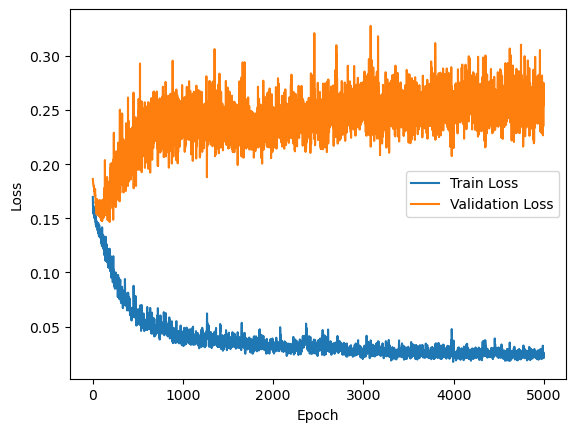

In [8]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

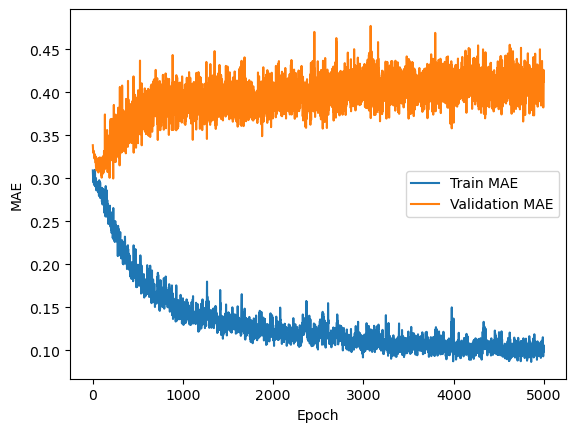

In [9]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [10]:
# Load the best weights based on the optimal epoch
model.load_weights(checkpoint_filepath)

In [11]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 187 loss: 0.1465522199869156


In [12]:
# Evaluate the model on the test set
results = model.evaluate(data_test, y_test)

75/75 [==============================] - 0s 500us/step


In [13]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 0.14655222694079081
Test MAE: 0.3005293905735016


[[1.         0.41423348]
 [0.41423348 1.        ]]
0.1625369131206651


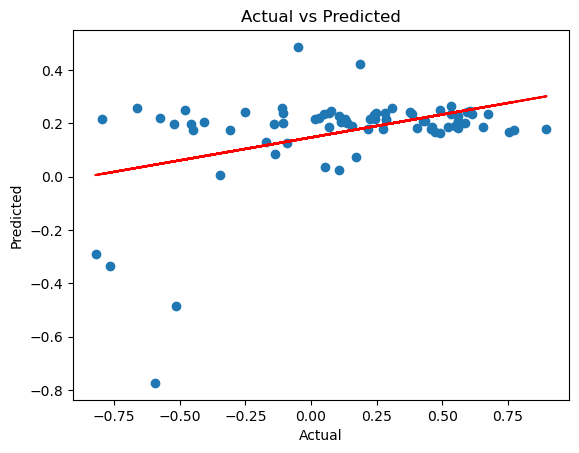

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = model.predict(data_test)
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [15]:
# Save model weights
# model.save_weights('../../data/conv1Dnet.h5')
# print("Model weights saved to '../../data/conv1Dnet.h5'")